In [13]:
import model1
from data import DataCollector
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
import torch.nn as nn
import torch
height = 512
width = 384
classes = {"cardboard":(0, 403),
        "glass":(1, 501),
        "metal":(2, 410),
        "paper":(3, 594),
        "plastic":(4, 482)}

classes_original = {"cardboard":(0, 34),
        "glass":(1, 20),
        "metal":(2, 26),
        "paper":(3, 42),
        "plastic":(4, 33)}

skin_tones = {0:(41, 23, 9),#darker
              1:(95, 51, 16),
              2:(127, 68, 34),
              3:(178, 102, 68),
              4:(115, 63, 23),
              5:(147, 95, 55),
              6:(173, 138, 96),
              7:(207, 150, 95),
              8:(187, 101, 54),
              9:(212, 158, 122),
              11:(242, 194, 128),
              12:(236, 192, 145),
              13:(249, 212, 160),
              14:(248, 217, 152),
              15:(253, 231, 173),
              16:(254, 227, 197)}#paler

In [205]:
import warnings
warnings.filterwarnings('ignore')
from torchvision.models import resnet34,ResNet34_Weights
import numpy as np
import cv2
from PIL import Image
from gradcam.utils import find_resnet_layer
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

In [252]:
def heatmap(class_label,img_idx,our_own_data = True,our_own_model=True):
    model = resnet34()
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 5)
    if our_own_model:
        model.load_state_dict(torch.load('models/seqno6_model4/model.pth'))
    else:
        model.load_state_dict(torch.load('models/seqno6_model1_train_final_layer/model.pth'))
    img = []
    if our_own_data:
        img = np.array(Image.open(f'original_trashnet/original_dataset/{list(classes.keys())[class_label]}/{list(classes.keys())[class_label]}{img_idx}.jpg'))
    else:
        img = np.array(Image.open(f'trashnet/dataset-resized/{list(classes.keys())[class_label]}/{list(classes.keys())[class_label]}{img_idx}.jpg'))
        
    # 最後の畳み込み層を取得
    target_layer = model.layer4[-1]
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = ResNet34_Weights.DEFAULT.transforms().mean,
        std = ResNet34_Weights.DEFAULT.transforms().std)
    ])
    input_tensor = preprocess(img)
    input_tensor = input_tensor.unsqueeze(0)
    # 勾配の計算を有効にする
    model.eval()
    for param in model.parameters():
        param.requires_grad_(False)
    input_tensor.requires_grad_(True)

    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    target_layer.register_forward_hook(get_activation('fc2'))

    # 順伝播を実行して、指定した層の出力を取得
    output = model(input_tensor)
    output = nn.functional.softmax(output, dim=1)
    output[:, class_label].backward()

    # 勾配を取得
    grads = input_tensor.grad.cpu().numpy()

    # 重みを計算
    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros((12, 16), dtype=np.float32)

    # 特徴マップを取得
    features = F.relu(activation['fc2']).cpu().numpy()[0]

    # 重みと特徴マップを掛け合わせて、Grad-CAMのヒートマップを作成
    for i, w in enumerate(weights[0]):
        cam += w* features[i, :, :]

    # ヒートマップを正規化
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (512, 384))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換

    # plt.imshow(jetcam)
    # plt.show()
    alpha = 0.7
    blended = cv2.addWeighted(np.uint8(img*255), alpha, jetcam, 1 - alpha, 0)
    # 結果を表示する。
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# TrashNet model against TrashNet

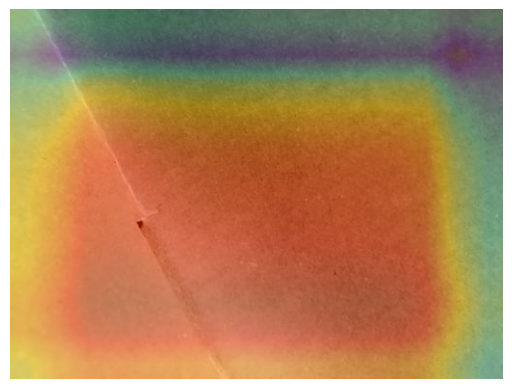

In [195]:
heatmap(0,5)

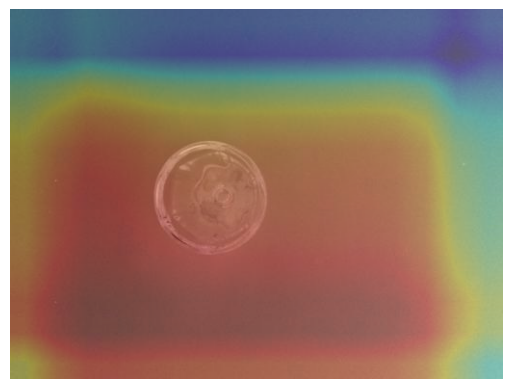

In [196]:
heatmap(1,5)

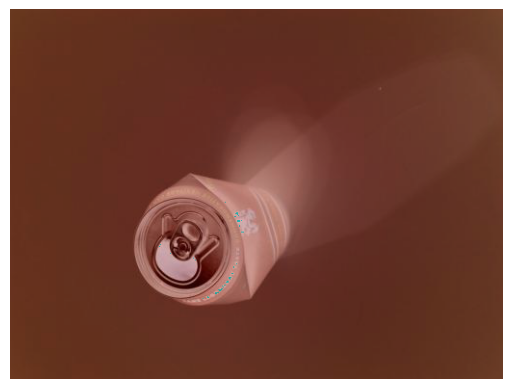

In [204]:
heatmap(2,3)

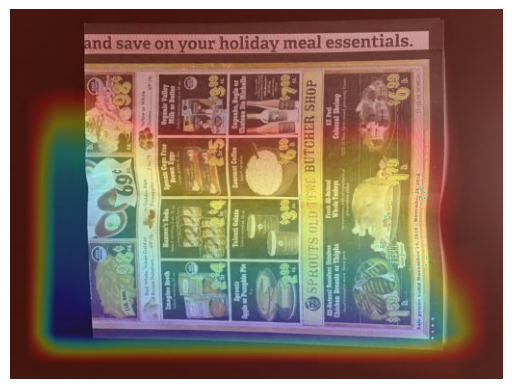

In [203]:
heatmap(3,4)

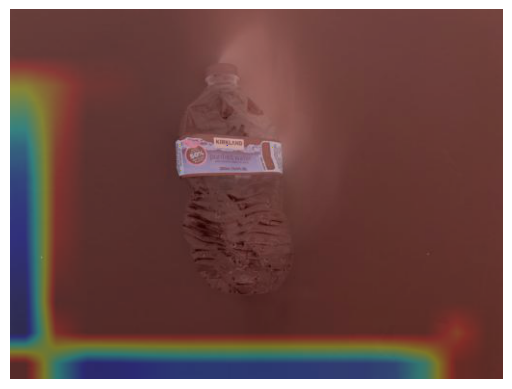

In [202]:
heatmap(4,5)

# our model against our own dataset

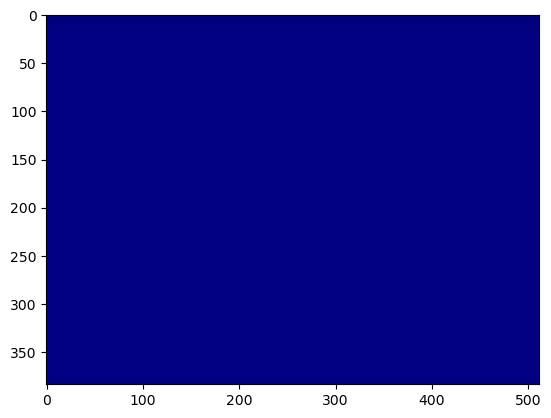

In [251]:
heatmap(2,15,True,True)

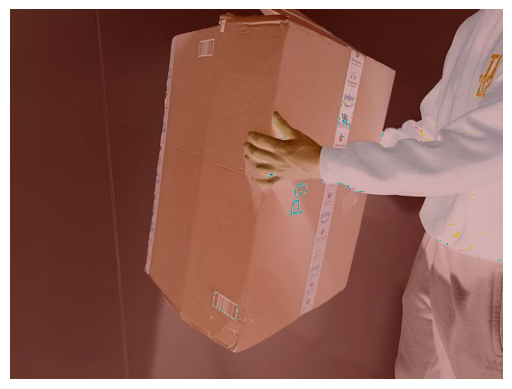

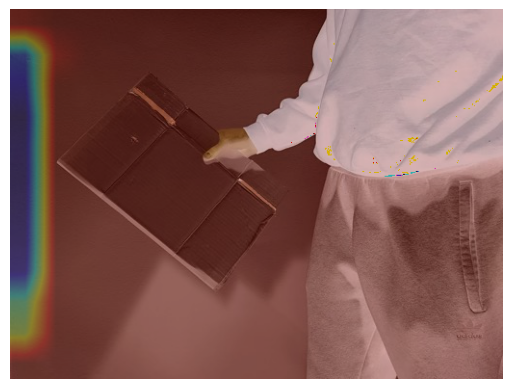

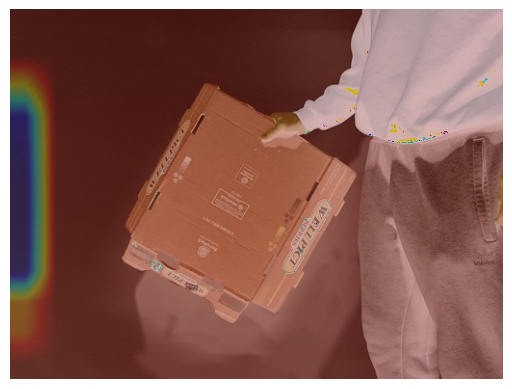

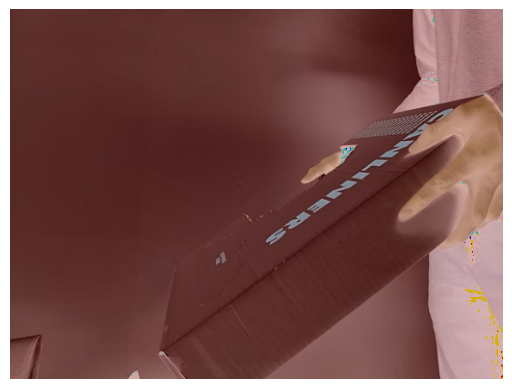

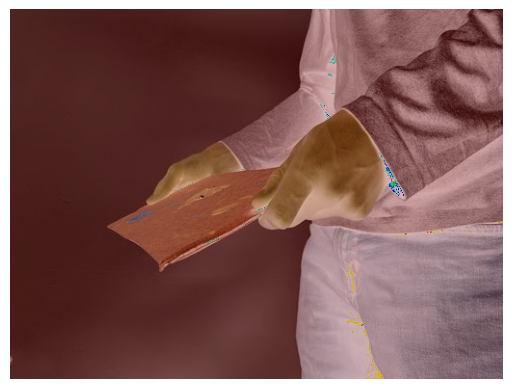

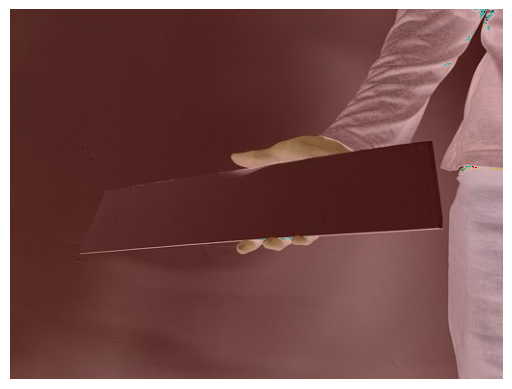

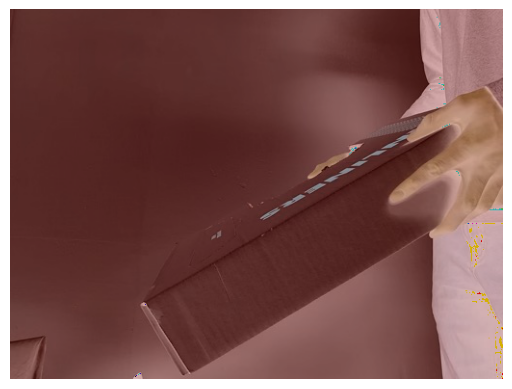

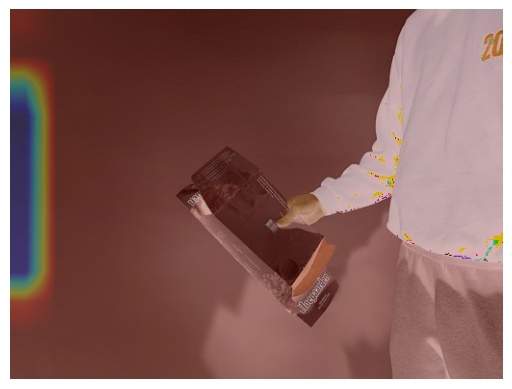

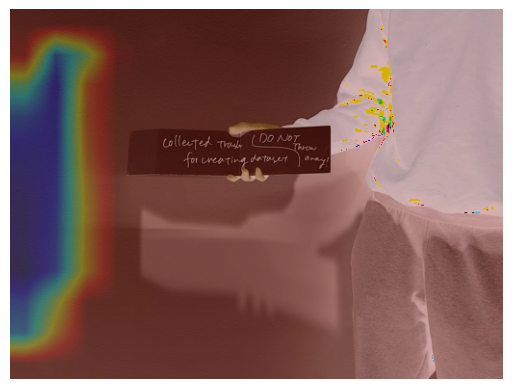

In [262]:
for i in range(11,20):
    heatmap(0,i,True,True)

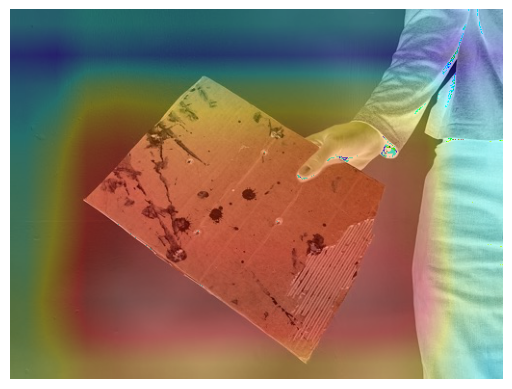

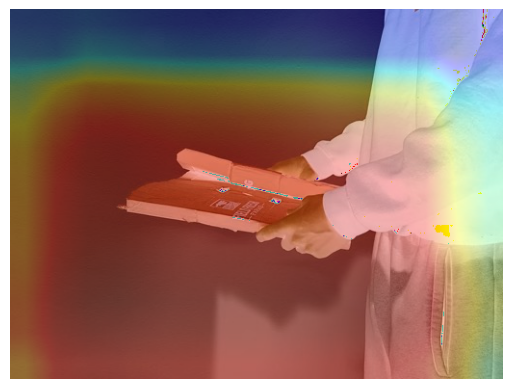

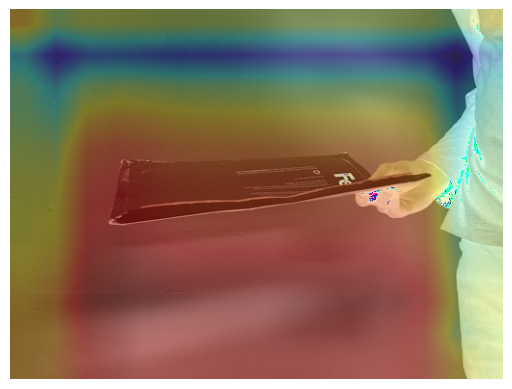

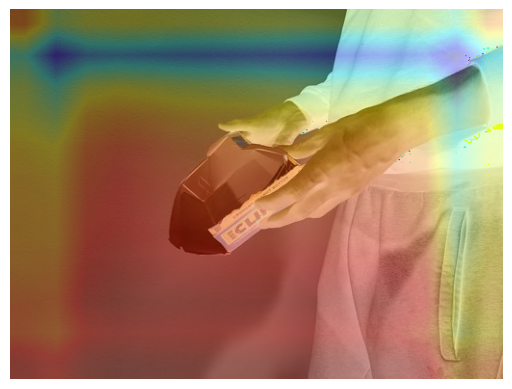

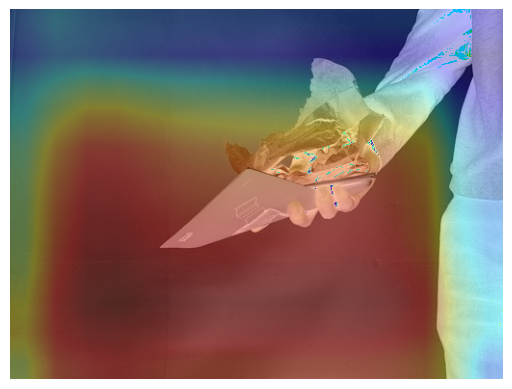

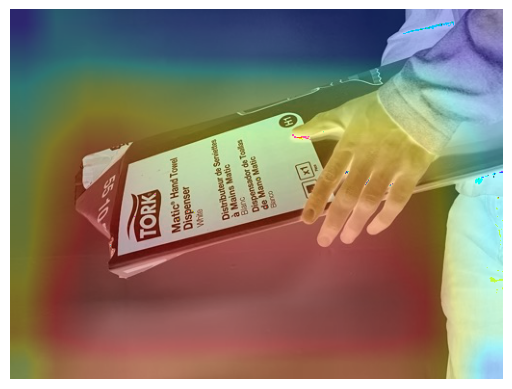

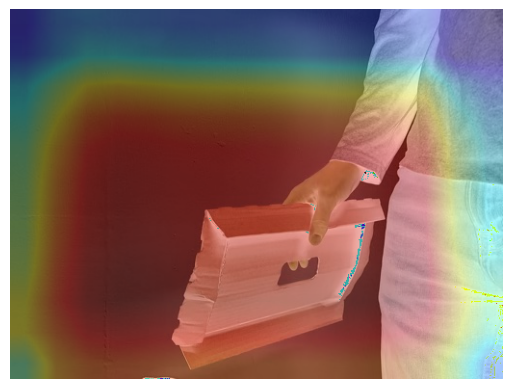

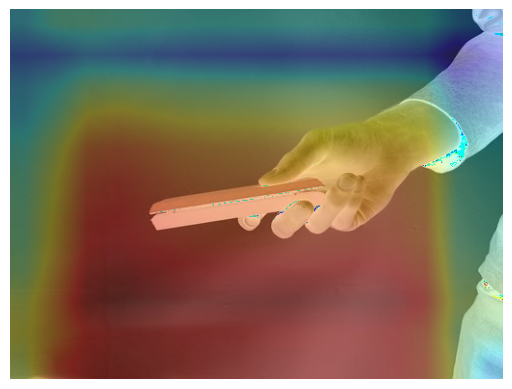

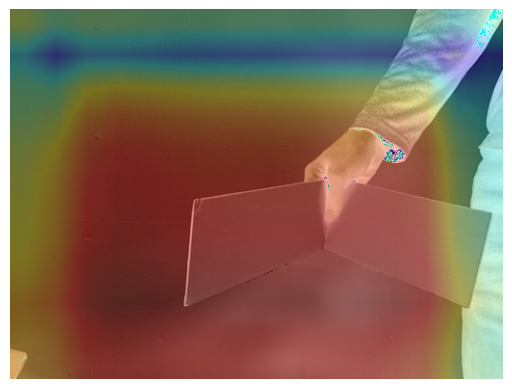

In [263]:
for i in range(21,30):
    heatmap(0,i,True,False)

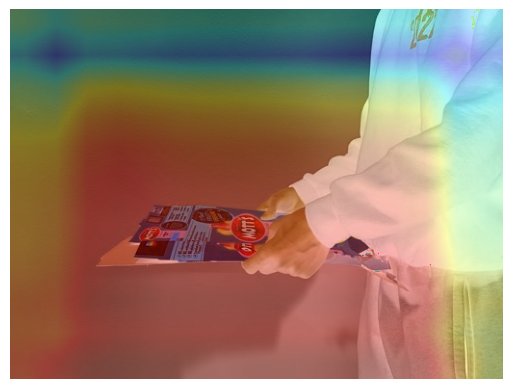

In [226]:
heatmap(0,10,True,False)

# previous model against our own dataset

In [ ]:
heatmap